# Well log wedge

Let's try to make a wedge model from a well log!

We'll try linear wedges and a sort of sigmoid thing.

**Watch out, this is all rather experimental.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

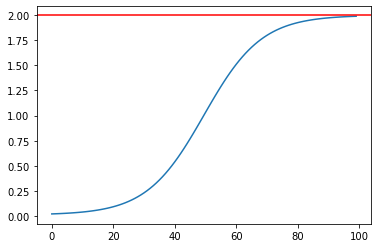

In [2]:
def sigmoid(start, stop, num):
    """
    Nonlinear space following a logistic function.
    
    The function is asymptotic; the parameters used in the sigmoid
    gets within 0.5% of the target thickness in a wedge increasing
    from 0 to 2x the original thickness.
    """
    x = np.linspace(-5.293305, 5.293305, num)
    return start + (stop-start) / (1 + np.exp(-x))

left, right = 0.01, 2
y = sigmoid(left, right, 100)
plt.plot(y)
plt.axhline(right, c='r')

In [3]:
def pad_func(before, after):
    """
    Padding function. Operates on vector *in place*,
    as per the np.pad documentation.
    """
    def pad_with(x, pad_width, iaxis, kwargs):
        x[:pad_width[0]] = before[-pad_width[0]:]
        x[-pad_width[1]:] = after[:pad_width[1]]
        return
    return pad_with

In [49]:
import scipy.ndimage as sn

def get_strat(strat, thickness, mode='stretch', kind='nearest', position=1, wedge=None, zoom_mode='nearest'):
    """
    Take a 'stratigraphy' (either an int, a tuple of ints, or a list-like of
    floats) and expand or compress it to the required thickness.
    
    'mode' can be 'stretch' or 'crop'
    
    `kind` can be 'nearest', 'linear', 'quadratic', or 'cubic'.
    """
    orders = {'nearest': 0, 'linear': 1, 'quadratic': 2, 'cubic': 3}
    order = orders.get(kind, 0)
    
    if isinstance(strat, int) and order==0:
        out = np.repeat([strat], thickness)
    elif isinstance(strat, float) and order==0:
        out = np.repeat([strat], thickness)
    elif isinstance(strat, tuple) and order==0:
        out = np.repeat(strat, int(round(thickness/len(strat))))
    else:
        if position == 0:
            wedge_zoom = wedge[1]/len(wedge[0])
            strat = strat[-int(thickness/wedge_zoom):]
        elif position == -1:
            wedge_zoom = wedge[1]/len(wedge[0])
            strat = strat[:int(thickness/wedge_zoom)]
        zoom = thickness / len(strat)
        out = sn.zoom(strat, zoom=zoom, order=order, mode=zoom_mode)
       
    # Guarantee correct length by adjusting bottom layer.
    missing = int(np.ceil(thickness - out.size))
    if out.size > 0 and missing > 0:
        out = np.pad(out, [0, missing], mode='edge')
    elif out.size > 0 and missing < 0:
        out = out[:missing]

    return out

get_strat((0, 1), 60)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [50]:
def get_conforming(strat, thickness, conformance):
    """
    Function to deal with top and bottom conforming wedges.
    """
    thickness = int(np.ceil(thickness))
    if thickness == 0:
        return np.array([])
    if strat.size == thickness:
        return strat
    elif strat.size > thickness:
        return strat[:thickness] if conformance == 'top' else strat[-thickness:]
    else:
        if conformance == 'top':
            return np.pad(strat, [0, thickness-strat.size], mode='wrap')
        else:
            return np.pad(strat, [thickness-strat.size, 0], mode='wrap')
    return

In [51]:
thick = 25
s = get_strat((0, 1, 0, 1, 0), thick)
assert s.size == thick

In [52]:
s = get_strat([0, 1, 0, 1, 0], thick)
assert s.size == thick

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple


def wedge(depth=(30, 40, 30),
          width=(10, 80, 10),
          breadth=None,  # Not implemented.
          strat=(0, 1, 2),
          thickness=(0.0, 1.0),
          mode='linear',
          conformance='both',
         ):
    """
    Generate a wedge model.
    
    Args:
        depth (int or tuple): The vertical size of the model. If a 3-tuple, then
            each element corresponds to a layer. If an integer, then each layer
            of the model will be 1/3 of the thickness. Note that if the 'right'
            wedge thickness is more than 1, then the total thickness will be
            greater than this value.
        width (int or tuple): The width of the model. If a 3-tuple, then each
            element corresponds to a 'zone' (left, middle, right). If an integer,
            then the zones will be 10%, 80% and 10% of the width, respectively.
        breadth (int or tuple): Not implemented. Raises an error.
        strat (tuple): Stratigraphy above, in, and below the wedge. This is the
            'reference' stratigraphy. If you give integers, you get 'solid' layers
            containing those numbers. If you give arrays, you will get layers of
            those arrays, expanded or squeezed into the layer thicknesses implied
            in `depth`. 
        thickness (tuple): The wedge thickness on the left and on the right.
            Default is (0.0, 1.0) so the wedge will be thickness 0 on the left
            and the wedge thickness specified in the depth argument on the right.
            If the thickness are equal, you'll have a flat, layer-cake model.
        mode (str): What kind of interpolation to use. Default: 'linear'. Other
            option is 'sigmoid', which makes a clinoform-like body.
        conformance (str): 'top', 'bottom', or 'both' (the default). How you want
            the layers inside the wedge to behave. For top and bottom conformance,
            if the layer needs to be thicker than the reference
        
    Returns:
        namedtuple[ndarray, ndarray, ndarray, int]: A tuple containing the
            2D wedge model, the top 'horizon', the base 'horizon', and the
            position at which the wedge has thickness 1 (i.e. is the thickness
            specfied by the middle layer depth and/or strat).
        
    TODO
    - Nearest interp ints, but linear interp floats (e.g. rock properties).
    - Breadth argument implements the third dimension.
    - If the wedge layer is a tuple of two ints, e.g. (1, 2, 1, 2, 1), then
        you are making a 'binary wedge', which has special features.
    """
    if breadth is not None:
        raise NotImplementedError("The breadth argument is not implemented yet.")

    # Allow wedge to be thin-thick or thick-thin.
    left, right = thickness
    if left > right:
        left, right = right, left
        flip = True
    else:
        flip = False
    
    if isinstance(depth, int):
        L1, L2, L3 = 3 * [depth//3]  # Sizes if depth is just a number.
        L3 += 1
    else:
        L1, L2, L3 = map(int, depth)
    L3 += int(right * L2)  # Adjust bottom layer.
    
    if isinstance(width, int):
        Z1, Z2, Z3 = width // 10, int(0.8 * zones), zones // 10
    else:
        Z1, Z2, Z3 = width  # Z1 and Z3 are the bookends.
        
    if mode == 'linear':
        zooms = np.linspace(left, right, Z2)
    elif mode in ['clinoform', 'sigmoid']:
        zooms = sigmoid(left, right, Z2)
    else:
        raise TypeError("Mode not recognized.")

    # Get the reference stratigraphy in each layer.
    # The 'well log' case is tricky, because layer1 and layer3
    # need to know about the amount of zoom on the wedge layer.
    # There must be an easier way to do this.
    layer1 = get_strat(strat[0], L1, position=0, wedge=(strat[1], L2))
    layer2 = get_strat(strat[1], L2, position=1)
    layer3 = get_strat(strat[2], L3, position=-1, wedge=(strat[1], L2))

    padder = pad_func(layer1, layer3)

    # Collect wedge pieces, then pad top & bottom, then stack, then pad left & right.
    if conformance in ['top', 'bottom', 'base']:
        wedges = [get_conforming(layer2, z*L2, conformance) for z in zooms]
    else:
        wedges = [get_strat(layer2, thickness=z*L2) for z in zooms]
    padded = [np.pad(w, [L1, L3-w.size], mode=padder) for w in wedges] 
    wedge = np.pad(np.stack(padded), [[Z1, Z3], [0, 0]], mode='edge')

    # Make the top and base 'horizons'.
    top = np.ones(np.sum(width)) * L1
    base = np.pad(L1 + zooms * L2, [Z1, Z3], mode='edge')
    
    # Calculate the reference profile ('well' position).
    if left <= 1 <= right:
        ref = Z1 + np.argmin(np.abs(zooms-1))
    elif left == right == 1:
        ref = Z1 + Z2//2
    else:
        ref = -1
        
    if flip:
        wedge = np.flipud(wedge)
        base = base[::-1]
        ref = sum(width) - ref
    
    Wedge = namedtuple('Wedge', ['wedge', 'top', 'base', 'reference'])
    return Wedge(wedge.T, top, base, ref)

## Floats

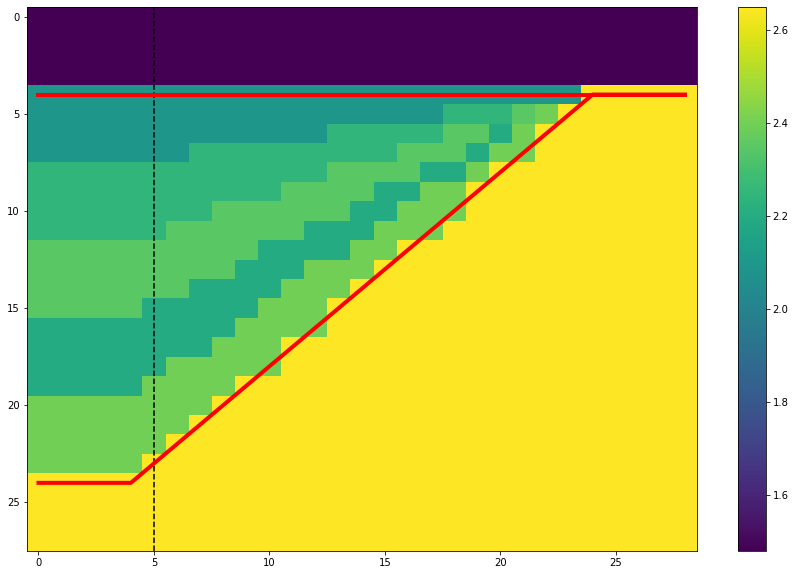

In [103]:
w, top, base, ref = wedge(depth=(4., 20, 4),
                          width=(4, 21, 4),
                          strat=(1.48, (2.10, 2.25, 2.35, 2.20, 2.40), 2.65),
                          thickness=(1, 0.),
                          mode='linear',
                         )

plt.figure(figsize=(15, 10))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.colorbar()

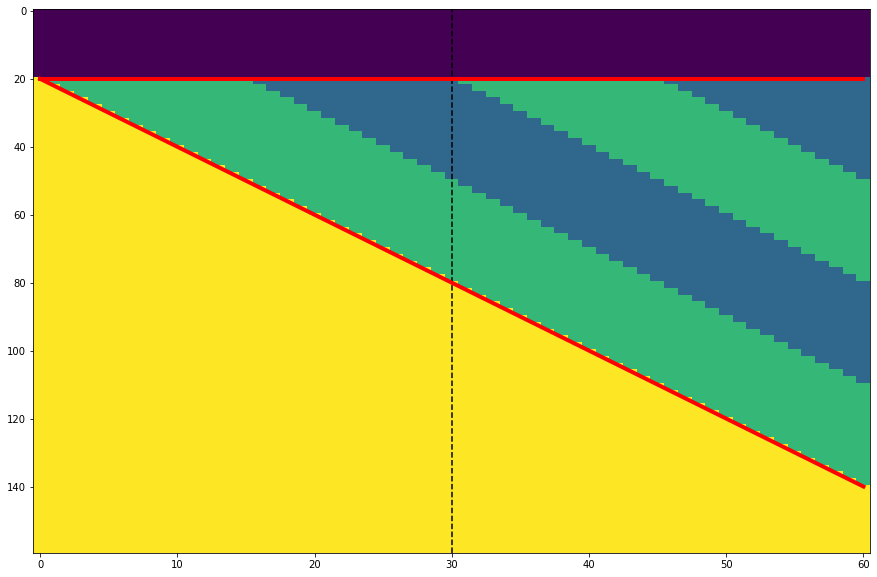

In [105]:
w, top, base, ref = wedge(depth=(20, 60, 20),
                          width=(0, 61, 0),
                          strat=(0, (1,2), 3),
                          mode='linear',
                          conformance='bottom',
                          thickness=(0, 2)
                         )

plt.figure(figsize=(15, 10))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)

200 600 180 [200.         203.35195531 206.70391061 210.05586592 213.40782123
 216.75977654 220.11173184 223.46368715 226.81564246 230.16759777
 233.51955307 236.87150838 240.22346369 243.57541899 246.9273743
 250.27932961 253.63128492 256.98324022 260.33519553 263.68715084
 267.03910615 270.39106145 273.74301676 277.09497207 280.44692737
 283.79888268 287.15083799 290.5027933  293.8547486  297.20670391
 300.55865922 303.91061453 307.26256983 310.61452514 313.96648045
 317.31843575 320.67039106 324.02234637 327.37430168 330.72625698
 334.07821229 337.4301676  340.78212291 344.13407821 347.48603352
 350.83798883 354.18994413 357.54189944 360.89385475 364.24581006
 367.59776536 370.94972067 374.30167598 377.65363128 381.00558659
 384.3575419  387.70949721 391.06145251 394.41340782 397.76536313
 401.11731844 404.46927374 407.82122905 411.17318436 414.52513966
 417.87709497 421.22905028 424.58100559 427.93296089 431.2849162
 434.63687151 437.98882682 441.34078212 444.69273743 448.04469274


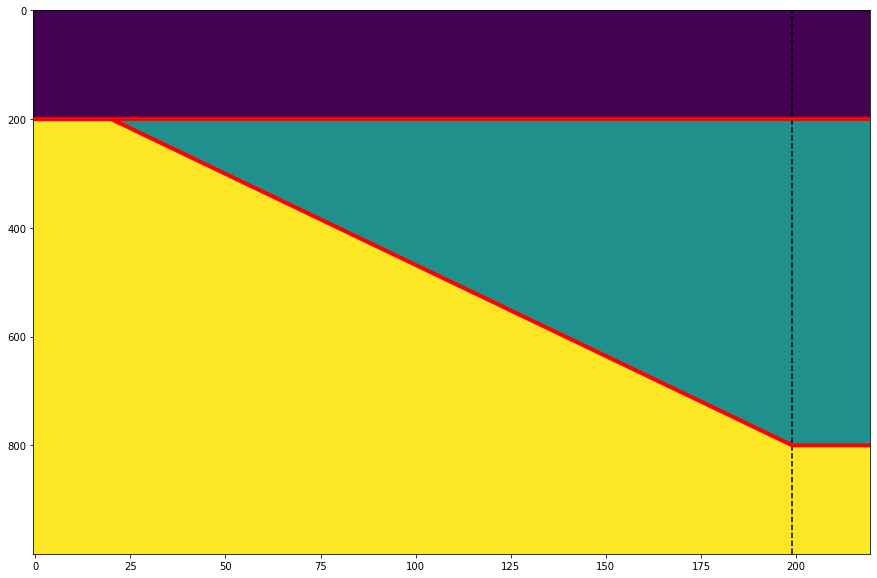

In [95]:
w, top, base, ref = wedge(depth=(200, 600, 200), width=(20, 180, 20), strat=(0, 1, 2), mode='linear')

plt.figure(figsize=(15, 10))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)

In [80]:
w.shape, top.shape

((100, 60), (60,))

In [71]:
from welly import Well

w = Well.from_las('../data/R-39.las')

log, top, bot = 'GR', 2620, 2625

log_before = w.data[log].to_basis(stop=top)
log_wedge = w.data[log].to_basis(start=top, stop=bot)
log_after = w.data[log].to_basis(start=bot)

/home/matt/anaconda3/envs/py39/lib/python3.9/site-packages/welly/well.py:193: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)


In [72]:
log_before.shape, log_wedge.shape, log_after.shape

((2802,), (33,), (5008,))

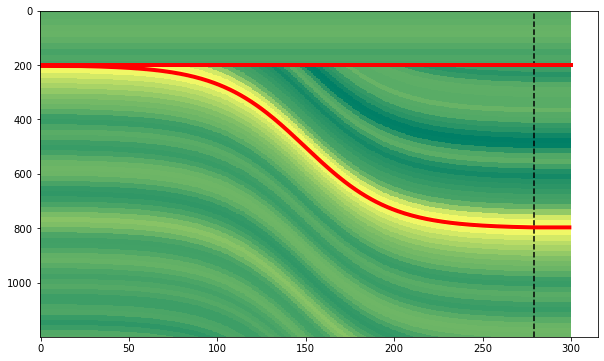

In [73]:
w, top, base, ref = wedge(depth=(200, 600, 400),
                          width=(20, 260, 20),
                          strat=(log_before, log_wedge, log_after),
                          mode='sigmoid', conformance='bottom',
                          thickness=(0, 1)
                         )

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', cmap='summer_r', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)

---
&copy; 2021 Agile Scientific, licensed CC-BY / Apache 2.0